# **Pax Only**

## 1. **Pre-processing**

### 1.1 Prequisites

In [1]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn_extra.cluster import KMedoids, CommonNNClustering
from yellowbrick.cluster import SilhouetteVisualizer

import sklearn as sk
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
import configparser
import warnings
warnings.filterwarnings("ignore")

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')
mapbox_token = config['mapbox']['secret_token']

### 1.2 Reading the edited csv file and renaming columns for ease of understanding.

In [3]:

# Read the CSV file
df = pd.read_csv('data/conflict_data.csv')

# Rename the features of the dataframe
df.rename(columns={'id': 'ID', 
                    'year': 'Year', 
                    'month': 'Month', 
                    'type_of_violence': 'Type',
                    'side_a': 'Side A',
                    'side_b': 'Side B',
                    'side_a_new_id': 'Side A ID',
                    'side_b_new_id': 'Side B ID',
                    'dyad_new_id': 'CID',
                    'dyad_name': 'Actors',
                    'where_coordinates': 'Location',
                    'where_prec': 'Where',
                    'latitude': 'Lat',
                    'longitude': 'Long',
                    'best': 'Casualties'}, inplace=True)

# Filter for the data we want to use
df = df[(df['Where'] < 5)]
df = df[df["ID"] != 121726]

# Output the head of the dataframe
df.head()

,ID,Year,Month,Type,Side A ID,Side A,Side B ID,Side B,Where,Location,Lat,Long,Casualties
0,123403,1989,1,1,5,Government of Philippines,6,CPP,1,Manila City,14.6042,120.9822,42.0
1,124029,1989,1,1,5,Government of Philippines,6,CPP,1,Makilala town,6.9514,125.0992,8.0
2,125199,1989,1,1,5,Government of Philippines,6,CPP,1,Sultan Kudarat town,7.2700,124.3106,4.0
3,122856,1989,2,1,5,Government of Philippines,6,CPP,4,Aurora province,16.0000,121.7500,4.0
4,123430,1989,2,1,5,Government of Philippines,6,CPP,2,Manila City,14.6042,120.9822,4.0


### 1.3 Fitting the geolocation within the Philippines.



In [4]:

px.set_mapbox_access_token(mapbox_token)

# Create a scatter geo figure with the df as the data frame, and the lat and long features as the coordinates
fig2 = px.scatter_mapbox(
    df, 
    lat="Lat", 
    lon="Long"
)                        

# Update the plot to center on the Philippines
fig2.update_geos(
    center=dict(lat=14.5995, lon=120.9842),
    fitbounds="locations",
)

# Set the title and dimensions of the plot.
fig2.update_layout(
    height=500,
    width=800,
    title="Conflict Data",
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_token,
        center=go.layout.mapbox.Center(lat=11.75, lon=122.2691),
        bearing=0,
        pitch=0,
        zoom=4,
        style="light"
    )
)

# Show the Plot
fig2.show()

### 1.4 Selection of columns relevant for the computation of clusters and normalization of data.
Further, additional columns were dropped to retain only the necessary data for computing the clusters.

In [5]:
# Create a new dataframe with the data we want to use for K-Means clustering
df2 = df.drop(['ID', 'Where', 'Month', 'Location', 'Year', 'Side A', 'Side B', 'Casualties'], axis=1)

# Use skikit-learn preprocessing to normalize the data
X = sk.preprocessing.normalize(df2, axis=0, norm='max')

# Create a new dataframe with the normalized data
X = pd.DataFrame(X, columns=df2.columns)

# Print the head of the new dataframe
X.head()

,Type,Side A ID,Side B ID,Lat,Long
0,0.333333,0.208333,0.214286,0.790996,0.955928
1,0.333333,0.208333,0.214286,0.376503,0.988458
2,0.333333,0.208333,0.214286,0.393759,0.982227
3,0.333333,0.208333,0.214286,0.866596,0.961994
4,0.333333,0.208333,0.214286,0.790996,0.955928


## **2. Clustering**


### 2.1 Finding the possible optimal numbers of clusters: The Silhouette analysis

Optimal number of clusters found is K = 5 with Silhouette Score = 66.58

In [6]:
# Create the inertial matrix for the data
inertia = []

# Create a for loop to iterate through the number of clusters to find the optimal cluster
optimal = 0
silhouette_score = 0
for i in range(2, 100):
    # Create a new K-Means model with the number of clusters
    kmeans = KMeans(n_clusters=i, 
                    n_init=10, 
                    tol=1e-4, 
                    random_state=42)
    # Fit the model to the data
    kmeans.fit(X)

    new_score = sk.metrics.silhouette_score(X, kmeans.labels_)

    optimal = i if new_score > silhouette_score else optimal

    silhouette_score = max(new_score, silhouette_score)

    # Append the inertia to the list
    inertia.append(kmeans.inertia_)

print(f"Optimal Cluster value found at {optimal} with {silhouette_score*100:.2f} Silhouette Score")

Optimal Cluster value found at 5 with 66.58 Silhouette Score


### 2.2  Finding the possible optimal numbers of clusters: Sum of Squared Error (SSE).

Optimal number of clusters is K = 5.

In [7]:
# Create a figure to display the inertia values
fig = go.Figure(data=go.Scatter(x=np.arange(1,100), y=inertia))

# Update the layout of the plot to set the title and dimensions
fig.update_layout(
    title="Inertia vs Cluster Number",xaxis=dict(range=[0,100],title="Cluster Number"),
    yaxis={'title':'Inertia'},
    height=500,
    width=800,
    annotations=[
    dict(
        x=5,
        y=inertia[4],
        xref="x",
        yref="y",
        text="Elbow!",
        showarrow=True,
        arrowhead=7,
        ax=20,
        ay=-40
    )
])

## **3. Results, Performance, and Analysis**

### 3.1 Implementing the K-means clustering algorithm with K = 5.

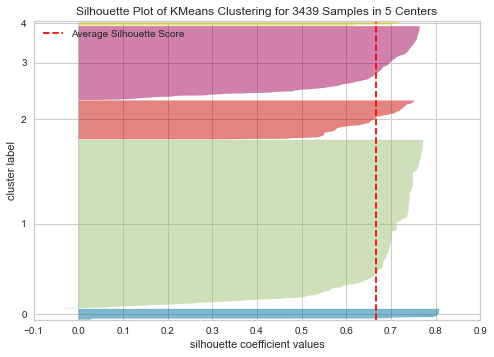

In [8]:
# Create a new K-Means model with the number of clusters of the elbow value
kmeans = KMeans(
    n_clusters=optimal,
    init="k-means++",
    n_init=10,
    random_state=42,
    tol=1e-4,
    max_iter=100
)

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
# Fit the visualizer to the data
visualizer.fit(X)
# Show the plot
visualizer.show()

# Create a new dataframe with the cluster labels
X['Cluster'] = kmeans.labels_.astype(str)

### 3.2 Plot the Cluster Parameters.

In [9]:
polar = X.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", title="Cluster Parameters", theta="variable", color="Cluster", line_close=True, height=500, width=500)
fig4.show()

### 3.3 Display the Cluster Distribution

In [10]:
pie = X.groupby('Cluster').size().reset_index()
pie.columns=['Cluster','value']
px.pie(pie,values='value',names='Cluster', height=500,width=500, title="Cluster Distribution")

### 3.4 Plot the conflict data through the map.

In [11]:
df['Cluster'] = kmeans.labels_
df['Cluster'] = df['Cluster'].astype(str)

px.set_mapbox_access_token(mapbox_token)
fig2 = px.scatter_mapbox(df, 
                        lat="Lat", 
                        lon="Long",
                        size="Casualties",
                        color="Cluster",
                        hover_name="Location",
                        hover_data=["ID", "Year", "Type", "Casualties", "Side A", "Side B"],
                        )
fig2.update_geos(
    fitbounds="locations",
)
fig2.update_layout(
    height=500,
    width=800,
    hovermode='closest',
    title="Conflict Clusters",
    mapbox=dict(
        accesstoken=mapbox_token,
        center=go.layout.mapbox.Center(lat=11.75, lon=122.2691),
        bearing=0,
        pitch=0,
        zoom=4,
        style="light",
        
    )
)
fig2.show()

## **4. Comparison to Other Models** 

### 4.1 K-Medoids Clustering

In [12]:
# Create a new dataframe with the data we want to use for K-Means clustering
df2 = df.drop(['ID', 'Where', 'Month', 'Location', 'Year', 'Side A', 'Side B', 'Casualties', 'Cluster'], axis=1)

# Use skikit-learn preprocessing to normalize the data
X = sk.preprocessing.normalize(df2, axis=0, norm='max')

# Create a new dataframe with the normalized data
X = pd.DataFrame(X, columns=df2.columns)

# Print the head of the new dataframe
X.head()

kmedoids = KMedoids(n_clusters=optimal, random_state=0).fit(X)
score = sk.metrics.silhouette_score(X, kmedoids.labels_)
print(f"Silhouette Score: {score*100:.2f}%")

X['Cluster'] = kmeans.labels_.astype(str)

polar = X.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", title="Cluster Parameters", theta="variable", color="Cluster", line_close=True, height=500, width=500)
fig4.show()

df['Cluster'] = kmedoids.labels_
df['Cluster'] = df['Cluster'].astype(str)

px.set_mapbox_access_token(mapbox_token)
fig2 = px.scatter_mapbox(df, 
                        lat="Lat", 
                        lon="Long",
                        size="Casualties",
                        color="Cluster",
                        hover_name="Location",
                        hover_data=["ID", "Year", "Type", "Casualties", "Side A", "Side B"],
                        )
fig2.update_geos(
    fitbounds="locations",
)
fig2.update_layout(
    height=500,
    width=800,
    hovermode='closest',
    title="Conflict Clusters",
    mapbox=dict(
        accesstoken=mapbox_token,
        center=go.layout.mapbox.Center(lat=11.75, lon=122.2691),
        bearing=0,
        pitch=0,
        zoom=4,
        style="light",
        
    )
)
fig2.show()

Silhouette Score: 38.38%


### 4.2 CommonNN Clustering

In [13]:
# Create a new dataframe with the data we want to use for K-Means clustering
df2 = df.drop(['ID', 'Where', 'Month', 'Location', 'Year', 'Side A', 'Side B', 'Casualties', 'Cluster'], axis=1)

# Use skikit-learn preprocessing to normalize the data
X = sk.preprocessing.normalize(df2, axis=0, norm='max')

# Create a new dataframe with the normalized data
X = pd.DataFrame(X, columns=df2.columns)

# Print the head of the new dataframe
X.head()


clustering = CommonNNClustering(eps=0.2, min_samples=0).fit(X)
score = sk.metrics.silhouette_score(X, clustering.labels_)
print(f"Silhouette Score: {score*100:.2f}%")

X['Cluster'] = kmeans.labels_.astype(str)

polar = X.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", title="Cluster Parameters", theta="variable", color="Cluster", line_close=True, height=500, width=500)
fig4.show()

df['Cluster'] = clustering.labels_
df['Cluster'] = df['Cluster'].astype(str)

px.set_mapbox_access_token(mapbox_token)
fig2 = px.scatter_mapbox(df, 
                        lat="Lat", 
                        lon="Long",
                        size="Casualties",
                        color="Cluster",
                        hover_name="Location",
                        hover_data=["ID", "Year", "Type", "Casualties", "Side A", "Side B"],
                        )
fig2.update_geos(
    fitbounds="locations",
)
fig2.update_layout(
    height=500,
    width=800,
    hovermode='closest',
    title="Conflict Clusters",
    mapbox=dict(
        accesstoken=mapbox_token,
        center=go.layout.mapbox.Center(lat=11.75, lon=122.2691),
        bearing=0,
        pitch=0,
        zoom=4,
        style="light",
        
    )
)
fig2.show()

Silhouette Score: 61.09%


In [14]:
# Create a new dataframe with the data we want to use for K-Means clustering
df2 = df.drop(['ID', 'Where', 'Month', 'Location', 'Year', 'Side A', 'Side B', 'Casualties', 'Cluster'], axis=1)

# Use skikit-learn preprocessing to normalize the data
X = sk.preprocessing.normalize(df2, axis=0, norm='max')

# Create a new dataframe with the normalized data
X = pd.DataFrame(X, columns=df2.columns)

# Print the head of the new dataframe
X.head()


clustering = SpectralClustering(n_clusters=5, affinity='rbf').fit(X)
score = sk.metrics.silhouette_score(X, clustering.labels_)
print(f"Silhouette Score: {score*100:.2f}%")

X['Cluster'] = kmeans.labels_.astype(str)

polar = X.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", title="Cluster Parameters", theta="variable", color="Cluster", line_close=True, height=500, width=500)
fig4.show()

df['Cluster'] = clustering.labels_
df['Cluster'] = df['Cluster'].astype(str)

px.set_mapbox_access_token(mapbox_token)
fig2 = px.scatter_mapbox(df, 
                        lat="Lat", 
                        lon="Long",
                        size="Casualties",
                        color="Cluster",
                        hover_name="Location",
                        hover_data=["ID", "Year", "Type", "Casualties", "Side A", "Side B"],
                        )
fig2.update_geos(
    fitbounds="locations",
)
fig2.update_layout(
    height=500,
    width=800,
    hovermode='closest',
    title="Conflict Clusters",
    mapbox=dict(
        accesstoken=mapbox_token,
        center=go.layout.mapbox.Center(lat=11.75, lon=122.2691),
        bearing=0,
        pitch=0,
        zoom=4,
        style="light",
        
    )
)
fig2.show()

Silhouette Score: 66.77%
